In [1]:
import re
from os.path import join
from IPython.display import display

import matplotlib.pyplot as plt
import joblib
import pandas as pd
import numpy as np
import torch
import torch.utils.data as data_utils
from matplotlib.colors import ListedColormap
from sklearn.metrics import pairwise_distances

from lolip.attacks.torch.projected_gradient_descent import ProjectedGradientDescent
from lolip.models.torch_utils.archs import *
from lolip.variables import auto_var
from lolip.models.torch_model import TorchModel
from utils import params_to_dataframe

Train accuracy:  0.9586666666666667
Test accuracy:  0.952


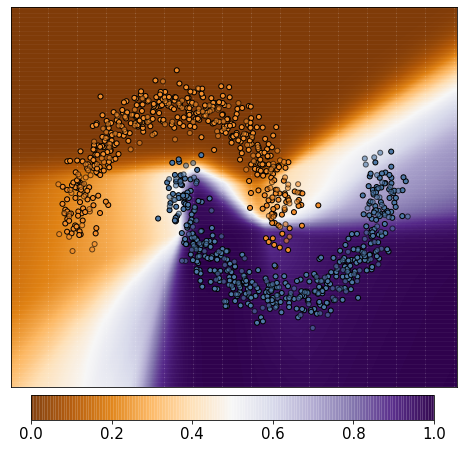

In [18]:
h = 0.01
def plot_boundary(clf, X, y, X_test, y_test):
    fig, ax = plt.subplots(figsize=(8, 7))

    cm = plt.cm.PuOr
    #cm = ListedColormap(['#F28E2C', '#4E79A7'])
    #cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    cm_bright = ListedColormap(['#F28E2C', '#4E79A7'])
    
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    #imshow_handle = plt.contourf(xx, yy, Z, cmap=cm, alpha=.8, vmin=0, vmax=1)
    imshow_handle = plt.pcolormesh(xx, yy, Z, cmap=cm, alpha=.8, vmin=0, vmax=1)
    imshow_handle.set_clim(0.0, 1.0)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright,
               edgecolors='black', s=25)
    # and testing points
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
               alpha=0.6, edgecolors='black', s=25)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    
    ax = plt.axes([0.16, 0.06, 0.7, 0.05])
    #plt.title("Probability")
    cbar = plt.colorbar(imshow_handle, cax=ax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=15) 
    
plot_boundary(model, trnX, trny, tstX, tsty)
print("Train accuracy: ", (model.predict(trnX) == trny).mean())
print("Test accuracy: ", (model.predict(tstX) == tsty).mean())

plt.savefig("./figs/halfmoon_proba.png", transparent=True)

In [7]:
dist = pairwise_distances(trnX, metric='chebyshev')
for i in range(len(trnX)):
    for j in range(len(trnX)):
        if trny[i] == trny[j]:
            dist[i][j] = np.inf
dist.min()

0.008569693315536475

In [3]:
attack = ProjectedGradientDescent(
    model_fn=model.model,
    norm=np.inf,
    eps=0.004,
    eps_iter=0.0008,
    nb_iter=10,
    preprocess_img=False,
    device='cpu',
)
print("adv trn acc: ", (model.predict(trnX + attack.perturb(trnX, trny)) == trny).mean())
print("adv tst acc: ", (model.predict(tstX + attack.perturb(tstX, tsty)) == tsty).mean())

adv trn acc:  0.8893333333333333
adv tst acc:  0.876


In [4]:
auto_var.set_variable_value("random_seed", 0)
trnX, trny, tstX, tsty = auto_var.get_var_with_argument("dataset", "halfmoon-1000-0.1")
#model = TorchModel(lbl_enc=None, n_features=(2, ), n_classes=2, loss_name="ce", architecture="LargeMLP", epochs=120, learning_rate=1e-2, device="cpu", batch_size=64)
#model = TorchModel(lbl_enc=None, n_features=(2, ), n_classes=2, loss_name="advce", architecture="LargeMLP", epochs=120, learning_rate=1e-2, device="cpu", batch_size=64, eps=0.004, norm=np.inf)
model = TorchModel(lbl_enc=None, n_features=(2, ), n_classes=2, loss_name="stradesce", architecture="LargeMLPv2", epochs=160, learning_rate=1e-2, device="cpu", batch_size=64, eps=0.004, norm=np.inf)
_ = model.fit(trnX, trny, verbose=0)
print((model.predict(trnX) == trny).mean())

Epoch 1:   0%|          | 0/12 [00:00<?, ?it/s]

lr: 0.001, opt: sgd, loss: stradesce, arch: LargeMLPv2, dataaug: None, batch_size: 64


Epoch 2:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.001
epoch: 1/160, train loss: 0.601, train acc: 0.809


Epoch 3:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.001
epoch: 2/160, train loss: 0.431, train acc: 0.853


Epoch 4:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.001
epoch: 3/160, train loss: 0.345, train acc: 0.869


Epoch 5:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.001
epoch: 4/160, train loss: 0.309, train acc: 0.880


Epoch 6:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.001
epoch: 5/160, train loss: 0.292, train acc: 0.892


Epoch 7:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.001
epoch: 6/160, train loss: 0.279, train acc: 0.899


Epoch 8:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.001
epoch: 7/160, train loss: 0.276, train acc: 0.904


Epoch 9:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.001
epoch: 8/160, train loss: 0.266, train acc: 0.893


Epoch 10:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.001
epoch: 9/160, train loss: 0.271, train acc: 0.895


Epoch 11:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.001
epoch: 10/160, train loss: 0.265, train acc: 0.900


Epoch 12:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.001
epoch: 11/160, train loss: 0.262, train acc: 0.896


Epoch 13:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.001
epoch: 12/160, train loss: 0.262, train acc: 0.899


Epoch 14:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.001
epoch: 13/160, train loss: 0.263, train acc: 0.899


Epoch 15:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.001
epoch: 14/160, train loss: 0.261, train acc: 0.901


Epoch 16:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.001
epoch: 15/160, train loss: 0.262, train acc: 0.905


Epoch 17:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.001
epoch: 16/160, train loss: 0.258, train acc: 0.909


Epoch 18:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.001
epoch: 17/160, train loss: 0.260, train acc: 0.908


Epoch 19:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.001
epoch: 18/160, train loss: 0.259, train acc: 0.907


Epoch 20:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.001
epoch: 19/160, train loss: 0.270, train acc: 0.907


Epoch 21:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.001
epoch: 20/160, train loss: 0.256, train acc: 0.907


Epoch 22:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.001
epoch: 21/160, train loss: 0.259, train acc: 0.909


Epoch 23:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.001
epoch: 22/160, train loss: 0.254, train acc: 0.908


Epoch 24:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.001
epoch: 23/160, train loss: 0.254, train acc: 0.911


Epoch 25:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.001
epoch: 24/160, train loss: 0.252, train acc: 0.919


Epoch 26:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.001
epoch: 25/160, train loss: 0.261, train acc: 0.907


Epoch 27:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.001
epoch: 26/160, train loss: 0.256, train acc: 0.920


Epoch 28:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.001
epoch: 27/160, train loss: 0.254, train acc: 0.912


Epoch 29:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.001
epoch: 28/160, train loss: 0.255, train acc: 0.916


Epoch 30:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.001
epoch: 29/160, train loss: 0.255, train acc: 0.917


Epoch 31:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.001
epoch: 30/160, train loss: 0.260, train acc: 0.916


Epoch 32:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.001
epoch: 31/160, train loss: 0.253, train acc: 0.923


Epoch 33:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.001
epoch: 32/160, train loss: 0.255, train acc: 0.908


Epoch 34:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.001
epoch: 33/160, train loss: 0.255, train acc: 0.920


Epoch 35:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.001
epoch: 34/160, train loss: 0.258, train acc: 0.913


Epoch 36:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.001
epoch: 35/160, train loss: 0.254, train acc: 0.916


Epoch 37:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.001
epoch: 36/160, train loss: 0.252, train acc: 0.916


Epoch 38:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.001
epoch: 37/160, train loss: 0.251, train acc: 0.927


Epoch 39:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.001
epoch: 38/160, train loss: 0.249, train acc: 0.923


Epoch 40:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.001
epoch: 39/160, train loss: 0.256, train acc: 0.919


Epoch 41:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.001
epoch: 40/160, train loss: 0.251, train acc: 0.927


Epoch 42:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.0001
epoch: 41/160, train loss: 0.248, train acc: 0.921


Epoch 43:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.0001
epoch: 42/160, train loss: 0.247, train acc: 0.923


Epoch 44:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.0001
epoch: 43/160, train loss: 0.248, train acc: 0.921


Epoch 45:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.0001
epoch: 44/160, train loss: 0.247, train acc: 0.923


Epoch 46:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.0001
epoch: 45/160, train loss: 0.248, train acc: 0.923


Epoch 47:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.0001
epoch: 46/160, train loss: 0.247, train acc: 0.924


Epoch 48:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.0001
epoch: 47/160, train loss: 0.247, train acc: 0.925


Epoch 49:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.0001
epoch: 48/160, train loss: 0.248, train acc: 0.921


Epoch 50:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.0001
epoch: 49/160, train loss: 0.247, train acc: 0.923


Epoch 51:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.0001
epoch: 50/160, train loss: 0.247, train acc: 0.927


Epoch 52:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.0001
epoch: 51/160, train loss: 0.247, train acc: 0.925


Epoch 53:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.0001
epoch: 52/160, train loss: 0.247, train acc: 0.924


Epoch 54:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.0001
epoch: 53/160, train loss: 0.247, train acc: 0.921


Epoch 55:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.0001
epoch: 54/160, train loss: 0.247, train acc: 0.927


Epoch 56:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.0001
epoch: 55/160, train loss: 0.247, train acc: 0.921


Epoch 57:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.0001
epoch: 56/160, train loss: 0.247, train acc: 0.924


Epoch 58:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.0001
epoch: 57/160, train loss: 0.247, train acc: 0.925


Epoch 59:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.0001
epoch: 58/160, train loss: 0.247, train acc: 0.924


Epoch 60:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.0001
epoch: 59/160, train loss: 0.247, train acc: 0.921


Epoch 61:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.0001
epoch: 60/160, train loss: 0.247, train acc: 0.924


Epoch 62:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.0001
epoch: 61/160, train loss: 0.247, train acc: 0.923


Epoch 63:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.0001
epoch: 62/160, train loss: 0.247, train acc: 0.925


Epoch 64:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.0001
epoch: 63/160, train loss: 0.247, train acc: 0.923


Epoch 65:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.0001
epoch: 64/160, train loss: 0.247, train acc: 0.924


Epoch 66:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.0001
epoch: 65/160, train loss: 0.247, train acc: 0.923


Epoch 67:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.0001
epoch: 66/160, train loss: 0.247, train acc: 0.923


Epoch 68:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.0001
epoch: 67/160, train loss: 0.247, train acc: 0.920


Epoch 69:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.0001
epoch: 68/160, train loss: 0.247, train acc: 0.925


Epoch 70:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.0001
epoch: 69/160, train loss: 0.247, train acc: 0.925


Epoch 71:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.0001
epoch: 70/160, train loss: 0.247, train acc: 0.924


Epoch 72:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.0001
epoch: 71/160, train loss: 0.247, train acc: 0.927


Epoch 73:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.0001
epoch: 72/160, train loss: 0.247, train acc: 0.925


Epoch 74:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.0001
epoch: 73/160, train loss: 0.247, train acc: 0.924


Epoch 75:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.0001
epoch: 74/160, train loss: 0.246, train acc: 0.927


Epoch 76:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.0001
epoch: 75/160, train loss: 0.247, train acc: 0.924


Epoch 77:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.0001
epoch: 76/160, train loss: 0.247, train acc: 0.927


Epoch 78:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.0001
epoch: 77/160, train loss: 0.247, train acc: 0.923


Epoch 79:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.0001
epoch: 78/160, train loss: 0.247, train acc: 0.924


Epoch 80:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.0001
epoch: 79/160, train loss: 0.247, train acc: 0.923


Epoch 81:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 0.0001
epoch: 80/160, train loss: 0.246, train acc: 0.923


Epoch 82:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000003e-05
epoch: 81/160, train loss: 0.246, train acc: 0.924


Epoch 83:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000003e-05
epoch: 82/160, train loss: 0.246, train acc: 0.924


Epoch 84:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000003e-05
epoch: 83/160, train loss: 0.246, train acc: 0.924


Epoch 85:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000003e-05
epoch: 84/160, train loss: 0.246, train acc: 0.924


Epoch 86:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000003e-05
epoch: 85/160, train loss: 0.246, train acc: 0.924


Epoch 87:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000003e-05
epoch: 86/160, train loss: 0.246, train acc: 0.923


Epoch 88:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000003e-05
epoch: 87/160, train loss: 0.246, train acc: 0.925


Epoch 89:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000003e-05
epoch: 88/160, train loss: 0.246, train acc: 0.925


Epoch 90:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000003e-05
epoch: 89/160, train loss: 0.246, train acc: 0.925


Epoch 91:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000003e-05
epoch: 90/160, train loss: 0.246, train acc: 0.924


Epoch 92:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000003e-05
epoch: 91/160, train loss: 0.246, train acc: 0.925


Epoch 93:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000003e-05
epoch: 92/160, train loss: 0.246, train acc: 0.925


Epoch 94:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000003e-05
epoch: 93/160, train loss: 0.246, train acc: 0.925


Epoch 95:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000003e-05
epoch: 94/160, train loss: 0.246, train acc: 0.925


Epoch 96:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000003e-05
epoch: 95/160, train loss: 0.246, train acc: 0.925


Epoch 97:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000003e-05
epoch: 96/160, train loss: 0.246, train acc: 0.925


Epoch 98:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000003e-05
epoch: 97/160, train loss: 0.246, train acc: 0.925


Epoch 99:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000003e-05
epoch: 98/160, train loss: 0.246, train acc: 0.925


Epoch 100:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000003e-05
epoch: 99/160, train loss: 0.246, train acc: 0.925


Epoch 101:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000003e-05
epoch: 100/160, train loss: 0.246, train acc: 0.925


Epoch 102:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000003e-05
epoch: 101/160, train loss: 0.246, train acc: 0.925


Epoch 103:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000003e-05
epoch: 102/160, train loss: 0.246, train acc: 0.925


Epoch 104:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000003e-05
epoch: 103/160, train loss: 0.246, train acc: 0.925


Epoch 105:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000003e-05
epoch: 104/160, train loss: 0.246, train acc: 0.925


Epoch 106:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000003e-05
epoch: 105/160, train loss: 0.246, train acc: 0.925


Epoch 107:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000003e-05
epoch: 106/160, train loss: 0.246, train acc: 0.925


Epoch 108:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000003e-05
epoch: 107/160, train loss: 0.246, train acc: 0.925


Epoch 109:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000003e-05
epoch: 108/160, train loss: 0.246, train acc: 0.925


Epoch 110:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000003e-05
epoch: 109/160, train loss: 0.246, train acc: 0.925


Epoch 111:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000003e-05
epoch: 110/160, train loss: 0.246, train acc: 0.925


Epoch 112:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000003e-05
epoch: 111/160, train loss: 0.246, train acc: 0.925


Epoch 113:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000003e-05
epoch: 112/160, train loss: 0.246, train acc: 0.925


Epoch 114:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000003e-05
epoch: 113/160, train loss: 0.246, train acc: 0.925


Epoch 115:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000003e-05
epoch: 114/160, train loss: 0.246, train acc: 0.925


Epoch 116:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000003e-05
epoch: 115/160, train loss: 0.246, train acc: 0.925


Epoch 117:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000003e-05
epoch: 116/160, train loss: 0.246, train acc: 0.925


Epoch 118:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000003e-05
epoch: 117/160, train loss: 0.246, train acc: 0.925


Epoch 119:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000003e-05
epoch: 118/160, train loss: 0.246, train acc: 0.925


Epoch 120:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000003e-05
epoch: 119/160, train loss: 0.246, train acc: 0.925


Epoch 121:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000003e-05
epoch: 120/160, train loss: 0.246, train acc: 0.925


Epoch 122:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000002e-06
epoch: 121/160, train loss: 0.246, train acc: 0.925


Epoch 123:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000002e-06
epoch: 122/160, train loss: 0.246, train acc: 0.925


Epoch 124:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000002e-06
epoch: 123/160, train loss: 0.246, train acc: 0.925


Epoch 125:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000002e-06
epoch: 124/160, train loss: 0.246, train acc: 0.925


Epoch 126:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000002e-06
epoch: 125/160, train loss: 0.246, train acc: 0.925


Epoch 127:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000002e-06
epoch: 126/160, train loss: 0.246, train acc: 0.925


Epoch 128:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000002e-06
epoch: 127/160, train loss: 0.246, train acc: 0.925


Epoch 129:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000002e-06
epoch: 128/160, train loss: 0.246, train acc: 0.925


Epoch 130:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000002e-06
epoch: 129/160, train loss: 0.246, train acc: 0.925


Epoch 131:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000002e-06
epoch: 130/160, train loss: 0.246, train acc: 0.925


Epoch 132:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000002e-06
epoch: 131/160, train loss: 0.246, train acc: 0.925


Epoch 133:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000002e-06
epoch: 132/160, train loss: 0.246, train acc: 0.925


Epoch 134:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000002e-06
epoch: 133/160, train loss: 0.246, train acc: 0.925


Epoch 135:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000002e-06
epoch: 134/160, train loss: 0.246, train acc: 0.925


Epoch 136:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000002e-06
epoch: 135/160, train loss: 0.246, train acc: 0.925


Epoch 137:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000002e-06
epoch: 136/160, train loss: 0.246, train acc: 0.925


Epoch 138:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000002e-06
epoch: 137/160, train loss: 0.246, train acc: 0.925


Epoch 139:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000002e-06
epoch: 138/160, train loss: 0.246, train acc: 0.925


Epoch 140:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000002e-06
epoch: 139/160, train loss: 0.246, train acc: 0.925


Epoch 141:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000002e-06
epoch: 140/160, train loss: 0.246, train acc: 0.925


Epoch 142:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000002e-07
epoch: 141/160, train loss: 0.246, train acc: 0.925


Epoch 143:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000002e-07
epoch: 142/160, train loss: 0.246, train acc: 0.925


Epoch 144:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000002e-07
epoch: 143/160, train loss: 0.246, train acc: 0.925


Epoch 145:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000002e-07
epoch: 144/160, train loss: 0.246, train acc: 0.925


Epoch 146:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000002e-07
epoch: 145/160, train loss: 0.246, train acc: 0.925


Epoch 147:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000002e-07
epoch: 146/160, train loss: 0.246, train acc: 0.925


Epoch 148:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000002e-07
epoch: 147/160, train loss: 0.246, train acc: 0.925


Epoch 149:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000002e-07
epoch: 148/160, train loss: 0.246, train acc: 0.925


Epoch 150:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000002e-07
epoch: 149/160, train loss: 0.246, train acc: 0.925


Epoch 151:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000002e-07
epoch: 150/160, train loss: 0.246, train acc: 0.925


Epoch 152:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000002e-07
epoch: 151/160, train loss: 0.246, train acc: 0.925


Epoch 153:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000002e-07
epoch: 152/160, train loss: 0.246, train acc: 0.925


Epoch 154:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000002e-07
epoch: 153/160, train loss: 0.246, train acc: 0.925


Epoch 155:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000002e-07
epoch: 154/160, train loss: 0.246, train acc: 0.925


Epoch 156:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000002e-07
epoch: 155/160, train loss: 0.246, train acc: 0.925


Epoch 157:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000002e-07
epoch: 156/160, train loss: 0.246, train acc: 0.925


Epoch 158:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000002e-07
epoch: 157/160, train loss: 0.246, train acc: 0.925


Epoch 159:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000002e-07
epoch: 158/160, train loss: 0.246, train acc: 0.925


Epoch 160:   0%|          | 0/12 [00:00<?, ?it/s]

current LR: 1.0000000000000002e-07
epoch: 159/160, train loss: 0.246, train acc: 0.925


Epoch 160: 100%|██████████| 12/12 [00:00<00:00, 45.70it/s]


current LR: 1.0000000000000002e-07
epoch: 160/160, train loss: 0.246, train acc: 0.925
0.9253333333333333
